# <center> Обучение с учителем. Классификация
## <center> Логистическая регрессия в sklearn

Мы будем работать со знакомым вам по модулю «Очистка данных» наборе данных о диабете, первоначально полученном в Национальном институте диабета, болезней органов пищеварения и почек.

Наша цель будет состоять в том, чтобы диагностически предсказать, есть ли у пациента диабет. На выбор экземпляров из более крупной базы данных было наложено несколько ограничений. В частности, все пациенты здесь — женщины не моложе 21 года из индейского племени Пима.

В модуле по очистке данных вы уже производили очистку этого набора данных:

* удалили дубликаты,
* удалили неинформативный признак Gender,
* обработали «скрытые» пропуски в данных,
* избавились от потенциальных выбросов.

Итак, импортируем библиотеки, необходимые нам для работы с данными:

In [6]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации


import warnings # для игнорирования предупреждений
#Игнорируем варнинги
warnings.filterwarnings('ignore')


# Устанавливаем стиль визуализаций в matplotlib
%matplotlib inline
#plt.style.use('seaborn')

Затем прочитаем нашу таблицу:

In [3]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.zip')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


Напомним, какие признаки у нас есть:

* Pregnancies — количество беременностей;
* Glucose — концентрация глюкозы в плазме через два часа при пероральном тесте на толерантность к глюкозе;
* BloodPressure — диастолическое артериальное давление (мм рт. ст.);
* SkinThickness — толщина кожной складки трицепса (мм);
* BMI — индекс массы тела (вес в кг/рост в $м^2$);
* DiabetesPedigreeFunction — функция родословной диабета (чем она выше, тем выше шанс наследственной заболеваемости);
* Age — возраст;
* Outcome — наличие диабета (0 — нет, 1 — да), целевой признак.

Размер таблицы:

In [3]:
print(diabetes_data.shape)

(757, 8)


Давайте посмотрим на матрицу корреляций и выберем наиболее коррелированные с целевым признаком факторы:

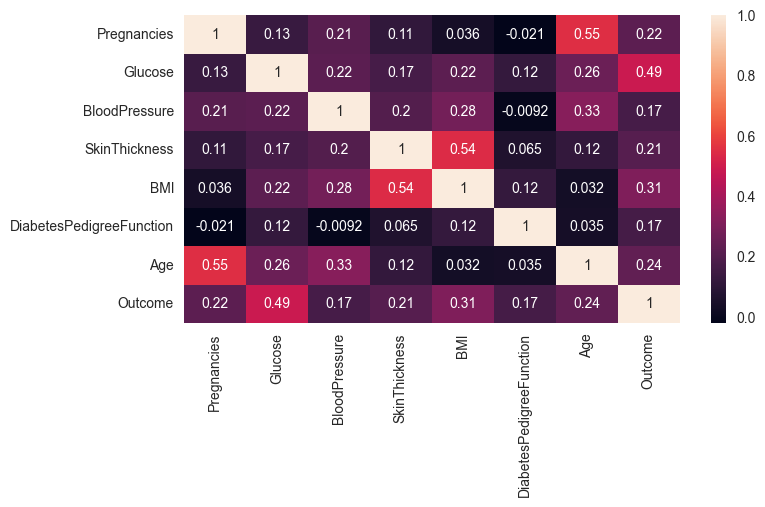

In [4]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.heatmap(diabetes_data.corr(), annot=True);

Из строки Outcome видно, что наибольшей корреляцией с целевым признаком обладают факторы Glucose (уровень глюкозы) и BMI (индекс массы тела).

Построим диаграмму рассеяния, по оси абсцисс отложим фактор Glucose, а по оси ординат — BMI. Сделаем цветовую группировку по признаку наличия диабета:

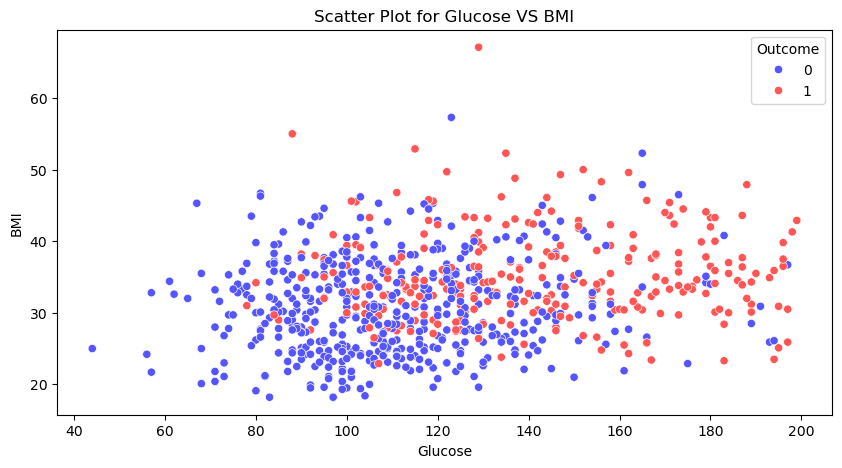

In [4]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, #датасет
    x='Glucose', #ось абсцисс
    y='BMI', #ось ординат
    hue='Outcome', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('Scatter Plot for Glucose VS BMI');

Видно, что классы довольно сильно перемешаны, но красные точки, соответствующие пациентам с диабетом, преимущественно сгруппированы в правой части системы координат.

Давайте попробуем построить разделяющую плоскость с помощью логистической регрессии.

Для начала разделим выборку на матрицу наблюдений `X`, состоящую из двух признаков, и столбец с правильным ответами `y`:

In [5]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

Логистическая регрессия — линейная модель, поэтому она находится в уже знакомом нам модуле `linear_model` из библиотеки `sklearn`.

In [31]:
from sklearn import linear_model #линейные модели

В модуле находится класс LogisticRegression, который реализует поиск коэффициентов разделяющей плоскости путём минимизации функции потерь logloss различными численными методами.



Основные параметры LogisticRegression:

* random_state — число, на основе которого происходит генерация случайных чисел.
* penalty — метод регуляризации. Возможные значения:
    * 'l1' — L1-регуляризация;
    * 'l2' — L2-регуляризация (используется по умолчанию);
    * 'elasticnet' — эластичная сетка (L1+L2);
    * None — отсутствие регуляризации.
* C — коэффициент обратный коэффициенту регуляризации, то есть равен . Чем больше C, тем меньше регуляризация. По умолчанию C=1, тогда α=1.
* solver — численный метод оптимизации функции потерь logloss, может быть:
    * 'sag' — стохастический градиентный спуск (нужна стандартизация/нормализация);
    * 'saga' — [модификация](https://arxiv.org/pdf/1407.0202.pdf) предыдущего, которая поддерживает работу с негладкими функциями (нужна стандартизация/нормализация);
    * 'newton-cg' — [метод Ньютона с модификацией сопряжённых градиентов](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#newton-conjugate-gradient-algorithm-method-newton-cg) (не нужна стандартизация/нормализация);
    * 'lbfgs' — [метод Бройдена — Флетчера — Гольдфарба — Шанно](https://ru.wikipedia.org/wiki/Алгоритм_Бройдена_—_Флетчера_—_Гольдфарба_—_Шанно) (не нужна стандартизация/нормализация; используется по умолчанию, так как из всех методов теоретически обеспечивает наилучшую сходимость);
    * 'liblinear' — [метод покоординатного спуска](http://www.machinelearning.ru/wiki/index.php?title=Метод_покоординатного_спуска) (не нужна стандартизация/нормализация).
* max_iter — максимальное количество итераций, выделенных на сходимость.

Обучим логистическую регрессию, сделав значением параметра `random_state`, например, число 42, чтобы гарантированно получить одинаковые результаты. Остальные параметры оставим по умолчанию.

Для обучения модели необходимо просто вызвать метод `fit()`, передав в него матрицу наблюдений `X` и вектор правильных ответов `y`.

Чтобы получить параметр $w_0$, нужно обратиться к атрибуту `intercept_`, а вектор параметров  $w_1$, $w_2$, ..., $w_m$  будет храниться в атрибуте `coef_` (так как в матрице `X` два фактора, то и коэффициента будет два):

In [ ]:
#Создаём объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42)
#Обучаем модель, минимизируя logloss
log_reg_2d.fit(X, y)
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [-8.24901758]
w1, w2: [[0.03779291 0.08757414]]


> В отличие от линейной регрессии, коэффициенты логистической регрессии интерпретировать сложнее. Мы не будем этим заниматься.

Как нам сделать предсказание вероятности наличия диабета у пациента?

Мы должны подставить значения факторов в уравнение разделяющей плоскости, а затем подставить результат в функцию сигмоиды. Для этого есть метод `predict_proba()`.

Например, появился новый пациент с концентрацией глюкозы 180 мг/100мл и индексом массы тела в 51 $кг/м^2$. Мы хотим вычислить вероятность наличия/отсутствия диабета у данного пациента:

In [8]:
#Значения концентации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание вероятностей:
y_new_proba_predict = log_reg_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 2)))

Predicted probabilities: [[0.05 0.95]]


Метод `predict_proba()` возвращает сразу две вероятности: первая соответствует вероятности принадлежности к классу 0 (диабета нет), а вторая — вероятности принадлежности к классу 1 (диабет есть). Заметьте, что в сумме две вероятности дают 1, что вполне логично, так как события взаимоисключающие.

Если мы хотим предсказать не вероятности, а сам класс (1 или 0), нам пригодится метод `predict()`. По умолчанию метод `predict()` относит объект к классу 1, если вероятность принадлежности к классу 1 > 0.5, и к классу 0, если эта вероятность < 0.5.

In [9]:
#Значения концентации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]
#Делаем предсказание класса:
y_new_predict = log_reg_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


Предсказанный класс равен 1, значит, модель считает, что данный пациент болеет диабетом.

Теперь построим визуализацию нашей модели.

Чтобы красиво визуализировать вероятности в виде тепловой карты, мы подготовили специальную функцию — `plot_probabilities_2d()`.

Данная функция принимает три аргумента:

* `X` — матрица с наблюдениями,
* `y` — столбец с правильными ответами,
* `model` — модель, с помощью которой делается предсказание вероятностей.

> Мы не будем подробно останавливаться на работе данной функции — она нам нужна только для красивой визуализации, но если вы захотите разобраться, мы написали подробные комментарии к каждой строке кода.

In [33]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199,
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказывает вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линия, где вероятность равна 0.5.
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

Теперь вызовем нашу функцию и посмотрим, как логистическая вероятность делит пространство на две части.

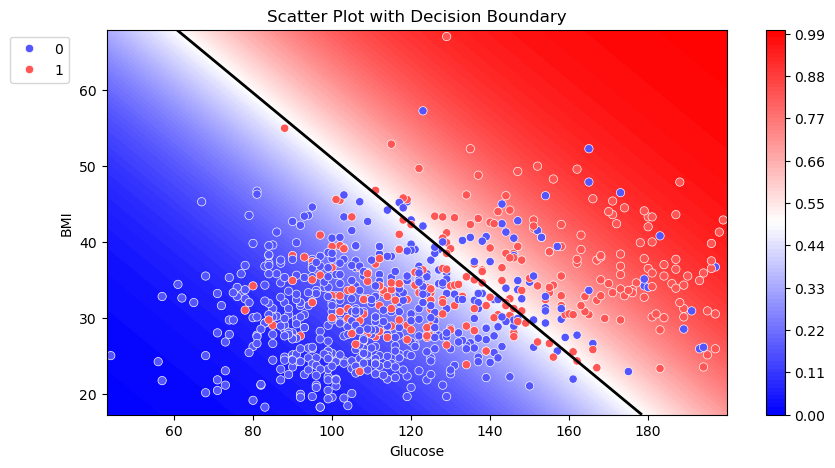

In [11]:
plot_probabilities_2d(X, y, log_reg_2d)

Мы видим разделяющую поверхность (обозначена чёрной линией). Она делит пространство на две части: красное соответствует точкам, которые будут отнесены моделью к классу 1, а синее соответствует точкам, которые будут отнесены моделью к классу 0.

Справа от графика есть цветовая панель, которая показывает значение вероятности того, что пациент болен диабетом (по мнению модели).

> Обратите внимание, что чем более точка удалена от разделяющей плоскости, тем с большей вероятностью модель относит её к тому или иному классу. На тепловой карте это прослеживается в интенсивности синего и красного цвета.


Из графика видно, что довольно много синих точек попали в красную зону и наоборот. Видимо, информации о двух факторах всё же маловато для того, чтобы хорошо провести классификацию.

Давайте будем использовать для построения модели всю предоставленную нам информацию — все факторы из набора данных. Для этого заново создадим матрицу наблюдений `X` и вектор ответов `y`:

In [12]:
#Создаем матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

Затем обучим модель логистической регрессии с помощью метода `fit()`.

Сделаем предсказание вероятности заболевания диабетом для каждого пациента и самих классов с помощью методов `predict_proba()` и `predict()`.

Затем добавим предсказание в таблицу `X` для наглядности:

In [13]:
#Создаем объект класса логистическая регрессия
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg_full.fit(X, y)
#Делаем предсказание класса
y_pred = log_reg_full.predict(X)
#Создадим временную таблицу X
X_temp = X.copy()
#Добавим в эту таблицу результат предсказания
X_temp['Prediction'] = y_pred
X_temp.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Prediction
752,5,139.0,64.0,35.0,28.6,0.411,26,0
753,1,96.0,122.0,29.0,22.4,0.207,27,0
754,10,101.0,86.0,37.0,45.6,1.136,38,1
755,0,141.0,72.0,29.0,42.4,0.205,29,1
756,0,125.0,96.0,29.0,22.5,0.262,21,0


Итак, мы сделали предсказание для каждого наблюдения (пациента) из таблицы `X`.

К сожалению, теперь, когда признаков больше двух, построить красивую визуализацию разделяющей плоскости не получится.

> Но как же тогда узнать, насколько хорошо модель определяет наличие диабета у пациента? Для этого используются метрики классификации, о которых мы поговорим в следующем юните.

Задание на пройденный материал:

Для выполнения задания скачайте набор данных [task_data](https://lms-cdn.skillfactory.ru/assets/courseware/v1/6a019aae7e83a8a11bb1fdf0788e3e6e/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/task_data.zip).

Таблица состоит из четырёх столбцов:

SNo — номер строки (данный столбец вам не понадобится, вы можете сразу его удалить);
X_1 и X_2 — факторы;
y — целевой признак.

Обучите модель логистической регрессии для предсказания целевого признака $y$. В качестве алгоритма оптимизации используйте` стохастический градиентный спуск` (масштабировать данные не нужно). В качестве значения параметра `random_state` возьмите число `42`, остальные параметры оставьте по умолчанию.

Воспользуйтесь функцией `plot_probabilities_2d()`, которую мы объявили ранее. Постройте визуализацию разделяющей поверхности.

Сколько объектов класса 0 будут `неверно` отнесены моделью к классу 1?

In [29]:
diabetes_data = pd.read_csv('data/task_data.zip')
diabetes_data = diabetes_data.drop('SNo',axis=1)
diabetes_data.head()


,X_1,X_2,y
0,-0.869144,0.389310,0.0
1,-0.993467,-0.610591,0.0
2,-0.834064,0.239236,0.0
3,-0.136471,0.632003,1.0
4,0.403887,0.310784,1.0


In [30]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['X_1', 'X_2']]
y = diabetes_data['y']

In [32]:
#Создаём объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42, solver='sag')
#Обучаем модель, минизируя logloss
log_reg_2d.fit(X, y)
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [0.55556317]
w1, w2: [[2.80981798 2.58767105]]


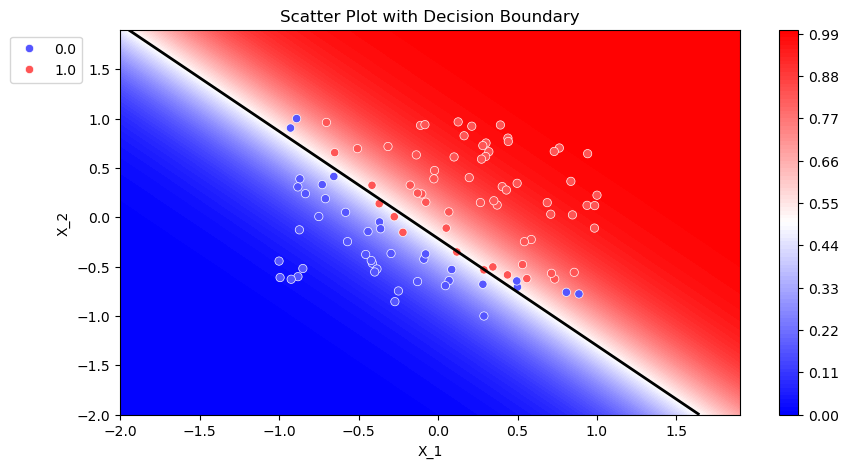

In [34]:
plot_probabilities_2d(X, y, log_reg_2d)

## Метрики классификации

Однако прежде чем мы перейдём к этим метрикам, нам очень важно освежить в памяти некоторую терминологию из статистики, а именно вспомнить, что такое ошибки I и II рода.

> Примечание. Напомним, что с определением ошибок I и II рода мы знакомились в модуле «EDA-4. Статистические тесты».

#### ОШИБКИ I И II РОДА С ТОЧКИ ЗРЕНИЯ КЛАССИФИКАЦИИ

Давайте рассмотрим предсказания алгоритма  на конкретном объекте  под номером из данных  с точки зрения статистических гипотез.

Будем считать класс 1 (диабет есть) положительным исходом (Positive), а класс 0 (диабета нет) — отрицательным (Negative).

> Примечание. На первый взгляд такая терминология может показаться не совсем этичной, так как наличие диабета — это всё-таки отрицательный сценарий для пациента. Однако для унификации терминологии в машинном обучении в большинстве задач объекты класса 1 считаются объектами с наличием некоторого эффекта (болезнь есть / задолженность погашена / клиент ушёл / устройство отказало и т. д.), а объекты класса 0 — объектами с отсутствием этого эффекта (болезни нет / задолженность не погашена / клиент не ушёл / устройство работает без отказов и т. д.).

Пусть у нас есть некоторый пациент $x_i$, и мы хотим понять, болен ли он диабетом. С точки зрения задачи классификации мы хотим предсказать истинный класс ($y_i$) пациента.

Нулевая гипотеза будет состоять в отсутствии эффекта (пациент не болен диабетом), то есть $y_i = 0$, а альтернативная — в его наличии (пациент болен диабетом) , то есть $y_i = 1$. В терминах статистических гипотез это будет записано так:

- $H_0$ Пациент $x_i$ не болеет диабетом $y_i = 0$.
- $H_1$ Пациент $x_i$ болеет диабетом $y_i = 1$.

Тогда у нас есть два случая, в которых мы можем допустить ошибку:

- `Ошибка I` (первого) рода ($\alpha$-ошибка): отклонение нулевой гипотезы, когда она на самом деле верна, или ложноположительный результат. То есть мы предсказали, что пациент болен диабетом, хотя это не так.

- `Ошибка II` (второго) рода ($\beta$-ошибка): принятие нулевой гипотезы, когда она на самом деле ложна, или ложноотрицательный результат. То есть мы предсказали, что пациент здоров, хотя на самом деле он болен диабетом.

>Примечание. Как вы можете понять, в диагностических задачах для нас критичнее ошибка II рода. Последствия будут более серьёзными, если мы примем больного пациента за здорового, чем если мы примем здорового за больного. Нам важно охватить всех потенциально больных пациентов, чтобы сделать дополнительный анализ и удостовериться в результате.

Отлично, мы освежили в памяти ошибки I и II рода — это поможет нам понять суть метрик классификации. Давайте перейдём к ним.

#### МЕТРИКИ КЛАССИФИКАЦИИ

Будем рассматривать метрики для задачи классификации на следующем примере.

Мы случайным образом выбрали десять пациентов из нашей таблицы и моделью `log_reg_full` предсказали для них ответы:

$$
    y = (1,0,1,1,0,1,1,0,1,1) \\
    \hat{y} = (1,1,0,1,1,0,1,1,0,1)
$$

Все метрики, которые мы рассмотрим, основаны на `матрице ошибок`. С неё мы и начнём наш разбор.

> Матрица ошибок (`confusion matrix`) показывает все возможные исходы совпадения и несовпадения предсказания модели с действительностью. Используется для расчёта других метрик.

Допустим, что у нас есть два класса и алгоритм, предсказывающий принадлежность каждого объекта к одному из классов. Тогда каждая ячейка матрицы ошибок соответствует количеству объектов, попавших в одну из следующих четырёх категорий:

- Истинно положительные (`True Positive, TP`) — это объекты, обозначенные моделью как класс 1 ($\hat{y} = 1$) и действительно принадлежащие к классу 1 ($y = 1$).

- Ложноположительные (`False Positive, FP`) — это объекты, обозначенные моделью как класс 1 ($\hat{y} = 1$), но в действительности принадлежащие к классу 0 ($y = 0$). То есть это объекты, для которых модель совершила `ошибку I рода`.

- Истинно отрицательные (`True Negative, TN`) — это объекты, обозначенные моделью как класс 0 ($\hat{y} = 0$) и действительно принадлежащие к классу 0 ($y = 0$).

- Ложноотрицательные (`False Negative, FN`) — это объекты, обозначенные моделью как класс 0 ($\hat{y} = 0$), но в действительности принадлежащие к классу 1 ($y = 1$). То есть это объекты, для которых модель совершила `ошибку II рода`.

<img src='img/ML_3_3_1.png'>

Давайте посмотрим, как будет выглядеть матрица ошибок для нашего примера предсказаний модели `log_reg_full`:

||$\hat{y} = 0$|$\hat{y} = 1$|
|---|----------|-------------|
|$y = 0$|TN = 1|FP = 2|
|$y = 1$|FN = 3|TP = 4|

Для большей наглядности представим следующую ситуацию: у нас есть множество наблюдений двух классов (класс 1 — круги, класс 0 — квадраты). Пусть мы нарисовали некоторый круг и условились, что все объекты, лежащие в этом круге, мы будем считать классом 1, а объекты вне круга — классом 0. Тогда мы получим следующую картину:

<img src='img/ML_3_3_2.png'>

Таким образом, мы получили четыре группы объектов:

<img src='img/ml3-3_2_1.jpg'>

<img src='img/ML_3_3_3.png'>

Формально матрица ошибок не является метрикой, но на её основе составляются сами метрики классификации. Давайте перейдём к ним.

> Accuracy (достоверность/аккуратность) — доля правильных ответов модели среди всех ответов. Правильные ответы — это истинно положительные (True Positive) и истинно отрицательные ответы (True Negative):

$accurasy = \frac{TP+TN}{TP+TN+FN+FP}$

> Примечание. Нередко в русской литературе вы можете встретить перевод метрики `accuracy` как `«точность»`, однако так же на русский язык переводится метрика `precision`, о которой мы поговорим далее. Поэтому, если вы используете термин `«точность»`, старайтесь указывать, о какой именно метрике (`accuracy` или `precision`) идёт речь.

В виде диаграммы соотношение количества объектов, классы которых мы угадали и общего количества объектов записывается в следующем виде:

<img src='img/ML_3_3_4.png' width="25%" height="25%">

> Интерпретация: как много (в долях) модель угадала ответов.

Метрика изменяется в диапазоне `от 0 до 1`. Чем ближе значение к 1, тем больше ответов модель «угадала». 

Рассчитаем `accuracy` для нашего примера:

$accuracy = \frac{4+1}{4+2+3+1} = 0.5$

Итак, наша `accuracy` равна `0.5`, то есть модель сделала верное предсказание для `50 % пациентов из выборки`.

> `Accuracy` — самая простая и самая понятная метрика классификации, но у неё есть один существенный недостаток. Она бесполезна, если классы сильно несбалансированы. Продемонстрируем это следующим примером.

Допустим, мы хотим оценить работу спам-фильтра электронной почты. Спам-письма обозначены как `Positive` (1), а не спам — как `Negative` (0).

У нас есть 110 писем. Из них:

- 100 писем — не спам,
- 10 писем — спам.

Мы построили некоторый классификатор. Согласно результатам классификатора, из 100 писем класса «не спам» мы верно определили (отнесли к классу 0) 90, а оставшиеся 10 отнесли к классу «спам» (классу 1). То есть True Negative = 90, а False Positive = 10. Из 10 спам-писем мы верно определили 5 (отнесли к классу 1), а остальные 5 отнесли к классу «не спам» (классу 0). То есть True Positive = 5, а False Negative = 5.

Матрица ошибок будет иметь вид:
||$\hat{y} = 0$|$\hat{y} = 1$|
|---|----------|-------------|
|$y = 0$|TN = 90|FP = 10|
|$y = 1$|FN = 5|TP = 10|

Тогда accuracy:

$accuracy = \frac{5+90}{5+90+10+5}= 0.864$

Однако представим, что мы построили классификатор, который просто предсказывает все письма как «не спам», то есть `True Negative = 100`, `False Negative = 10`, `True Positive = 0`, `False Positive = 0`.

||$\hat{y} = 0$|$\hat{y} = 1$|
|---|----------|-------------|
|$y = 0$|TN = 100|FP = 0|
|$y = 1$|FN = 10|TP = 0|

Тогда accuracy будет равна:

$accuracy = \frac{0+100}{0+100+0+10}= 0.909$

Метрика выросла, однако наша «модель» не обладает никакой предсказательной силой, так как изначально мы хотели определять письма со спамом. Преодолеть это нам поможет переход с общей для всех классов метрики к отдельным показателям качества классов, а именно к метрикам `precision`, `recall` и `$F-мера$`.

> `Precision` (точность), или PPV (`Positive Predictive Value`) — это доля объектов, названных классификатором положительными и при этом действительно являющихся таковыми, по отношению ко всем названным положительными объектам.

$precision = \frac{TP}{TP+FP}$

В виде диаграммы соотношение количества объектов класса 1, которые мы угадали и количества объектов, которые мы приняли за класс 1, записывается следующим образом:

<img src='img/ML_3_3_5.png' width="25%" height="25%">

Метрика также изменяется от 0 до 1. 

> Интерпретация: способность отделить класс 1 от класса 0. Чем больше `precision`, тем меньше ложных попаданий. То есть чем ближе `precision` к 1, `тем меньше вероятность` модели `допустить ошибку I рода`.

Именно `precision` не позволяет записать все ответы в один класс, так как в таком случае резко возрастает значение `False Positive` и метрика снижается.

Рассчитаем `precision` для нашего примера:

$precision = \frac{4}{4+2} = 0.67$

Таким образом, количество названных моделью больных диабетом и при этом действительно являющихся больными составляет 67 % от всех пациентов.

> Precision нужен в задачах, где от нас требуется минимум ложных срабатываний. Чем выше «цена» ложноположительного результата, тем выше должен быть `precision`.

Например, по камерам видеонаблюдения мы автоматически выявляем признаки драки на улицах и отправляем наряд полиции для урегулирования конфликта. Однако штат сотрудников сильно ограничен, реагировать на любой признак конфликта мы не можем, поэтому мы хотим уменьшить количество ложных вызовов. В такой ситуации мы выберем такую модель, у которой наибольший `precision`.

> В предельном случае (когда `precision` равен 1) у модели отсутствуют ложноположительные срабатывания.

**Примечание**. Важно понимать, что данный вывод справедлив только для выборки, на которой мы оцениваем метрику, то есть это не означает, что модель вовсе не может допустить ложноположительных результатов. Однако чем больше выборка, на которой мы тестируем алгоритм, тем ближе к истине будет данный вывод.

`Recall` (полнота), или `TPR` (`True Positive Rate`) — это доля объектов, названных классификатором положительными и при этом действительно являющихся таковыми, по отношению ко всем объектам положительного класса.

$recal = \frac{TP}{TP+FN}$

Диаграмма:

<img src='img/ML_3_3_6.png' width="25%" height="25%">

Метрика изменяется от 0 до 1.

**Интерпретация**: способность модели обнаруживать класс 1 вообще, то есть охват класса 1. Заметьте, что метрика зависит от количества ложноотрицательных срабатываний. То есть чем ближе `recall` к 1, тем меньше вероятность модели допустить `ошибку II рода`.

Рассчитаем recall для нашего примера:

$recall = \frac{4}{4+3} = 0.57$

Итак, процент пациентов, которых модель определила к классу больных диабетом, среди всех действительно больных диабетом составляет 57%.

> `Recall` очень хорошо себя показывает в задачах, где важно найти как можно больше объектов, принадлежащих к классу 1.

Например, это различные задачи, в которых мы пытаемся определить наличие эффекта, который может привести к серьёзным последствиям. Это могут быть те же диагностические задачи или задачи, в которых мы прогнозируем вероятность отказа устройства, от работы которого зависят человеческие жизни.

Предельный случай (когда `recall` равен 1) означает, что модель нашла все объекты класса 1, например всех действительно больных пациентов. Однако метрика ничего не скажет о том, с какой точностью мы это сделали.

**Примечание**. Важно понимать, что данный вывод справедлив только для выборки, на которой мы оцениваем метрику, то есть это не означает, что модель вовсе не может допустить ложноотрицательных исходов. Однако чем больше выборка, на которой мы тестируем алгоритм, тем данный вывод будет ближе к истине.

Метрики `precision` и `recall` не зависят от сбалансированности классов и в совокупности дают довольно исчерпывающее представление о классификаторе. Однако на практике часто бывает так, что увеличение одной из метрик может привести к уменьшению другой.

> Концентрация только на одной метрике (`precision` или `recall`) без учёта второй — сомнительная идея.

> В битве за максимум `precision` для класса 1 побеждает модель, которая всегда будет говорить «нет». У неё вообще не будет ложноположительных срабатываний.

> В битве за максимум `recall` для класса 1 побеждает модель, которая всегда будет говорить «да». Она охватит все наблюдения класса 1, и у неё не будет ложноотрицательных срабатываний. 

> В реальности необходимо балансировать между двумя этими метриками.

Классическим примером является задача определения оттока клиентов.

Очевидно, что мы хотим найти как можно больше клиентов, которые потенциально могут уйти от нас. Чтобы повысить их лояльность, мы планируем использовать ресурсы колл-центра. Однако они ограничены и мы не можем звонить всем клиентам. Определив стратегию и ресурс для удержания клиентов, мы можем подобрать нужные пороги по `precision` и `recall`. Например, можно сосредоточиться на удержании только высокодоходных клиентов или тех, кто уйдёт с большей вероятностью. 

В таком случае нам подойдёт следующая метрика.

$F_\beta$ (F-мера) — это взвешенное среднее гармоническое между `precision` и `recall`:

$$
F_\beta = (1 + \beta^2)\frac{precision \cdot recal}{(\beta^2precision) + recal}
$$

где $\beta$ — это вес `precision` в метрике: чем больше $\beta$, тем больше вклад.

В частном случае, когда $\beta = 1$, мы получаем равный вклад для `precision` и `recall`, а формула будет выражать простое среднее гармоническое, или метрику $F_1$ ($F_1-мера$):

$$
F_1 = 2\frac{precision \cdot recal}{precision + recal}
$$

Рассчитаем метрику $F_1$ для нашего примера:

$$
F_1 = 2\frac{0.67 \cdot 0.57}{0.67 + 0.57} = 0.62
$$

> В чём преимущество $F_1-меры$?

Метрика равна своему максимуму (1), если и `precision`, и `recall` равны 1 (то есть когда отсутствуют как ложноположительные, так и ложноотрицательные срабатывания). Но если хотя бы одна из метрик будет близка к 0, то и $F_1$ будет близка к 0. 

> Несмотря на отсутствие бизнес-интерпретации, метрика $F_1$ является довольно распространённой и используется в задачах, где необходимо выбрать модель, которая балансирует между `precision` и `recall`.

Например, если цена дополнительной диагностики заболевания очень высока, то есть ложных срабатываний должно быть минимум, но при этом нам важно охватить как можно больше больных пациентов. 

**Примечание**. Ещё одно небольшое, но очень важное замечание: все суждения, которые мы привели по отношению к `precision`, `recall` и $F_1-мере$, относятся только `к классу 1`, так как эти метрики по умолчанию считаются для класса 1. Для решения большинства задач знания о значении этих метрик для класса 1 более чем достаточно, так как обычно нас интересует именно наличие некоторого эффекта.

Однако если вам по каким-то причинам необходимо рассчитать `precision`, `recall` и $F_1-меру$ для класса 0, для этого достаточно сделать перекодировку классов — поменять их обозначения местами или (при расчёте метрик с помощью библиотеки `sklearn`) изменить значение специального параметра `pos_label на 0.`

Давайте обобщим всё вышесказанное в виде таблицы:
|Название|Формула|Интерпретация и применение|Достоинства|Недостатки|Функция в модуле metrics библиотеки sklearn|
|--------|-------|--------------------------|-----------|----------|-------------------------------------------|
|ACCURACY ДОСТОВЕРНОСТЬ|$\frac{TP+TN}{TP+TN+FN+FP}$|Доля правильных ответов среди всех ответов модели. Применяется в задачах, где классы сбалансированы.|Очень легко интерпретировать. Автоматически можно посчитать процент ошибок модели как 1 - accuracy|Плохо показывает себя на сильно несбалансированных классах.|[accuracy_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)|
|PRECISION (ТОЧНОСТЬ)|$\frac{TP}{TP+FP}$|Способность модели отделять класс 1 от класса 0. Используется в задачах, где важно минимальное количество ложноположительных срабатываний модели.|Можно использовать на несбалансированных выборках.|Вычисляется только для положительного класса — класса 1. Для класса 0 показатель необходимо вычислять отдельно. Не даёт представления о том, как много объектов положительного класса из общей совокупности нашёл алгоритм (как много ложноотрицательных срабатываний допустил алгоритм)|[precision_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)|
|RECAL (ПОЛНОТА)|$\frac{TP}{TP+FN}$|Способность модели находить класс 1. <br>Используется в задачах, где важно охватить как можно больше объектов положительного класса (1), то есть уменьшить количество ложноотрицательных срабатываний.|Можно использовать на несбалансированных выборках.|Вычисляется только для положительного класса — класса 1. Для класса 0 показатель необходимо вычислять отдельно. Не даёт представления о том, насколько точно модель находит объекты положительного класса (как много ложноположительных срабатываний).|[recal_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)|
|$F_1-мера$|$2\frac{precision \cdot recal}{precision + recal}$|Нет бизнес-интерпретации.<br>Используется в задачах, где необходимо балансировать между precision и recall.|Даёт обобщённое представление о точности и полноте.<br>Максимум достигается, когда максимальны обе метрики, минимум — когда хотя бы одна из метрик равна 0.<br>При желании можно использовать обобщённый вариант — $F_\beta$, чтобы управлять вкладом precision в общую метрику.|Отсутствие интерпретации не даёт интуитивного понимания человеку, не знакомому с этой метрикой.|[f1_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)|

Теперь давайте посмотрим, как можно произвести расчёт метрик на Python.

Весь набор функций для вычисления метрик в sklearn находится в модуле [metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Давайте его импортируем:

In [2]:
from sklearn import metrics #метрики

Функции, которые нам понадобятся:

* confusion_matrix() — расчёт матрицы ошибок,
* accuracy_score() — расчёт accuracy,
* precision_score() — расчёт precision,
* recall_score() — расчёт recall,
* f1_score() — расчёт $F_1$-меры.


Каждая из этих функций первым аргументом принимает истинные ответы $y$, а вторым аргументом — предсказанные значения целевой переменной $\hat{y}$.

Давайте составим матрицы ошибок для моделей log_reg_2d и log_reg_full, которые мы обучили в прошлом юните.

Для этого сделаем предсказание наличия диабета для всех пациентов с помощью каждой из моделей:

In [ ]:
#Делаем предсказание моделью, обученной на двух признаках
y_pred1 = log_reg_2d.predict(diabetes_data[['Glucose', 'BMI']])
#Делаем предсказание моделью, обученной на всех признаках
y_pred2 = log_reg_full.predict(diabetes_data.drop('Outcome', axis=1))

Accuracy: 0.62
Precision: 0.75
Recall: 0.60
F1 score: 0.67


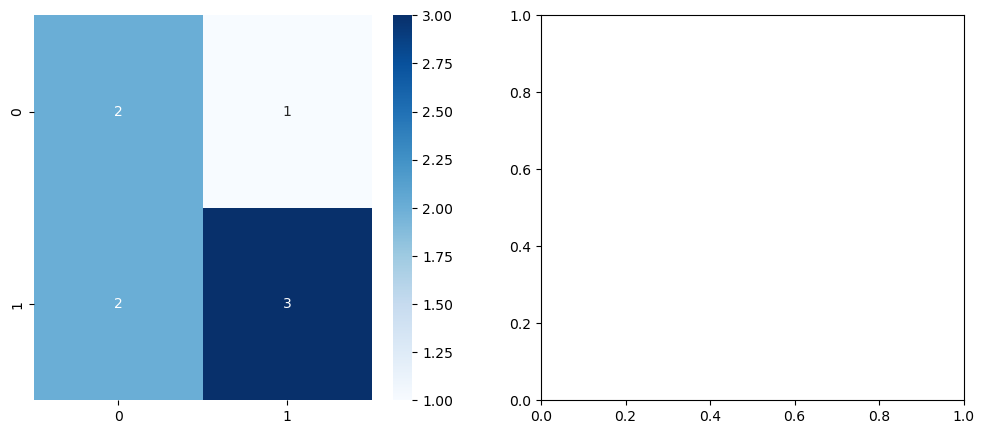

In [8]:
y = [0,0,1,1,1,1,0,1]
y_pred = [0,1,0,0,1,1,0,1]
conf_matrix = metrics.confusion_matrix(y, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #фигура + 2 координатные плоскости
sns.heatmap(conf_matrix, annot=True, fmt='',ax=axes[0], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ордина

#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred)))

Построим матрицы ошибок для каждой модели, а затем отобразим их в виде тепловых карт:

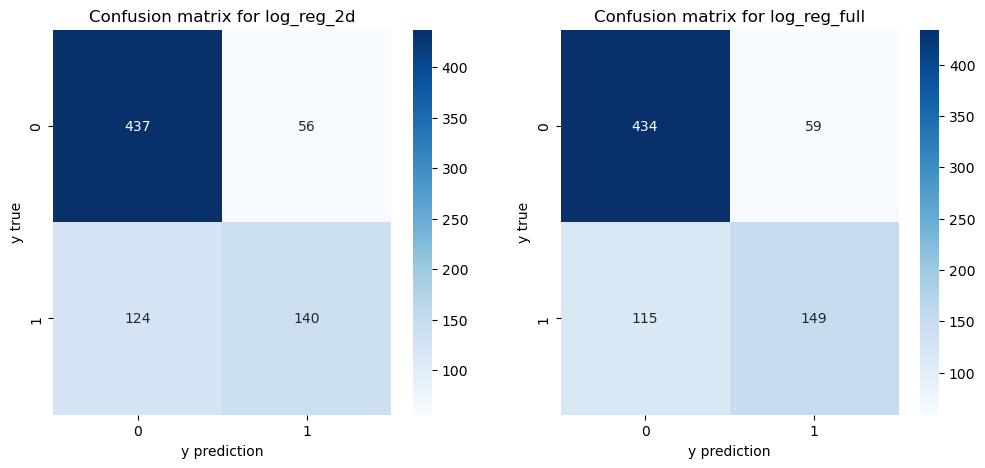

In [17]:
#Строим матрицы ошибок для каждой из моделей
confusion_matrix1 = metrics.confusion_matrix(y, y_pred1)
confusion_matrix2 = metrics.confusion_matrix(y, y_pred2)
#Визуализируем матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #фигура + 2 координатные плоскости
#Строим тепловую карту для первой матрицы ошибок
sns.heatmap(confusion_matrix1, annot=True, fmt='', ax=axes[0], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[0].set_title('Confusion matrix for log_reg_2d')
axes[0].set_xlabel('y prediction')
axes[0].set_ylabel('y true')
#Строим тепловую карту для второй матрицы ошибок
sns.heatmap(confusion_matrix2, annot=True, fmt='', ax=axes[1], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[1].set_title('Confusion matrix for log_reg_full')
axes[1].set_xlabel('y prediction')
axes[1].set_ylabel('y true');

Видно, что матрицы ошибок незначительно отличаются по своим составляющим. На их основе можно вручную вычислить остальные метрики для каждой из моделей, но мы воспользуемся встроенными функциями.

Расчёт метрик для модели `log_reg_2d`, обученной на двух факторах — Glucose и BMI:

In [18]:
#Модель log_reg_2d:
#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred1)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred1)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred1)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred1)))

Accuracy: 0.76
Precision: 0.71
Recall: 0.53
F1 score: 0.61


Расчёт метрик для модели `log_reg_full`, обученной на всех доступных факторах:

In [19]:
#Модель log_reg_full:
#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred2)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred2)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred2)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred2)))

Accuracy: 0.77
Precision: 0.72
Recall: 0.56
F1 score: 0.63


А теперь давайте сравним:

* Accuracy: доля правильных ответов для первой модели составляет 0.76, для второй — 0.77.
* Precision: способность первой модели отделять больных диабетом пациентов от здоровых пациентов составляет 0.71, а второй — 0.72.
* Recall: обобщающая способность находить больных пациентов среди всех пациентов для первой модели — 0.53, а для второй — 0.56.
* $F_1$: среднее гармоническое между precision и recall для первой модели составляет 0.61, а для второй — 0.63.

> Видно, что хоть и с небольшим отрывом, но вторая модель, обученная по всем признакам, превосходит первую модель по всем метрикам.

Для облегчения расчёта метрик можно использовать функцию `classification_report()` из модуля `metrics`. Она возвращает отчёт обо всех метриках классификации:

In [20]:
print(metrics.classification_report(y, y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       493
           1       0.72      0.56      0.63       264

    accuracy                           0.77       757
   macro avg       0.75      0.72      0.73       757
weighted avg       0.76      0.77      0.76       757



Что здесь отображено?

1. В первой части таблицы отображаются метрики precision, recall и f1-score, рассчитанные для каждого класса в отдельности. Столбец support — это количество объектов каждого из классов.
2. Во второй части таблицы отображена общая метрика accuracy. 
3. Далее идёт строка macro avg — это среднее значение метрики между классами 1 и 0. Например, значение в строке macro avg и столбце recall = (0.88 + 0.56)/2=0.72.
4. Завершает отчёт строка weighted avg — это средневзвешенное значение метрики между классами 1 и 0. Вес каждого класса определяется на основе доли объекта i-ого класса в выборке. Например, для случая двух классов метрика будет рассчитываться по формуле:

$$score_{weighted-avg} = \frac {n_{class_0}} {n} score_{class_0} + \frac {n_{class_1}} {n} score_{class_1}$$
где $n_{class_0}$ и $n_{class_1}$ — количество наблюдений класса 0 и 1 соответственно, $n$ — общее количество наблюдений в данных.

Ранее мы говорили о метриках precision, recall и $F_1$ только в контексте класса 1 (болеет диабетом). В отчёте `classification_report()` эти метрики рассчитаны и для класса 0. Смысл остаётся тем же, просто замените в рассуждениях класс 1 на класс 0.

Представим ситуацию, что дополнительная диагностика диабета в нашей клинике довольно дорогая. Но при этом нам важно выявить диабет у как можно большего числа людей. То есть нам важны и precision, и recall.

При этом наш recall равен 0.56, то есть мы находим только 56 % больных диабетом пациентов среди всех болеющих диабетом. Согласитесь, не очень хороший показатель (чуть выше половины). Можем ли мы его как-то улучшить?

Давайте будем изменять порог принятия решений. Сейчас порог составляет 0.5: то есть если вероятность наличия диабета у пациента выше 0.5, то модель относит его к больным диабетом, а если меньше 0.5 — к здоровым.

Но как будут меняться значения метрик recall, precision и $F_1$, если мы попробуем изменить порог вероятности, например на 0.4, 0.3 или 0.6? Давайте проследим за этим.

> **Примечание.** Геометрически регулировка порога вероятности для логистической регрессии означает движение разделяющей плоскости.

Сделаем предсказание вероятности наличия диабета моделью `log_reg_full` для каждого пациента из нашей выборки. Затем создадим несколько различных порогов вероятности в диапазоне от 0.1 до 1 с шагом 0.05. В цикле будем определять класс пациента при различных порогах вероятности. В конце рассчитаем метрики.

In [ ]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = log_reg_full.predict_proba(diabetes_data.drop('Outcome', axis=1))[:, 1]
#Для удобства завернём numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y, y_pred))
    precision_scores.append(metrics.precision_score(y, y_pred))
    f1_scores.append(metrics.f1_score(y, y_pred))

Теперь у нас есть три списка (recall_scores, precision_scores и f1_scores), в которых хранятся значения метрик при различных значениях порога вероятности `p`.

Давайте построим графики зависимости метрик от порога вероятности:

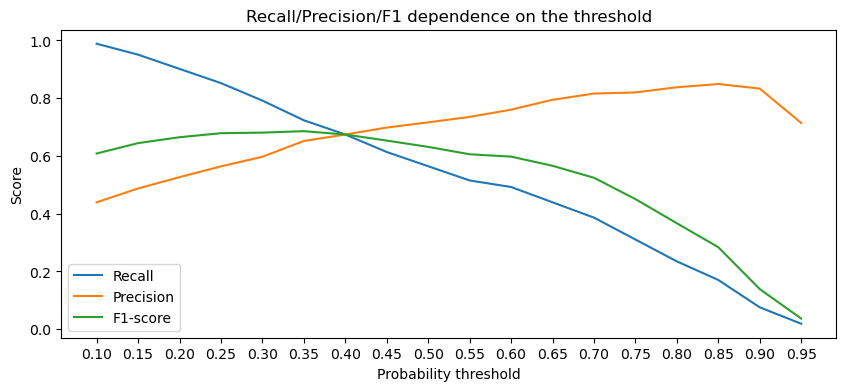

In [22]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds)
#Отображаем легенду
ax.legend();

Что мы видим на графике?

С увеличением вероятностного порога повышается precision и падает recall. Очевидно, что с увеличением порога вероятности мы начинаем классифицировать как диабетиков только тех пациентов, в диагнозе которых мы хорошо уверены, то есть мы повышаем точность (precision), но при этом мы отсекаем пациентов, которые больны, но модель выдаёт низкую вероятность болезни, то есть мы уменьшаем охват (recall).

При этом значение $F_1$-меры сначала немного повышается, а затем неуклонно падает.

Интересной является точка `threshold=0.4`, где происходит пересечение всех трёх графиков. Это точка равенства precision и recall и, как следует из формулы, равенства $F_1$-меры.

Однако максимум $F_1$-меры достигается в другой точке — `threshold=0.35`. При этом значения recall и precision в этой точке различны: recall выше, а вот precision ниже.

Перед нами стоит выбор, что всё-таки важнее: precision, recall или их равенство. Давайте сделаем выбор в пользу равенства precision и recall, оно достигается при `threshold=0.4`.

Как теперь мы можем сделать предсказание класса, обладая данной информацией?

Мы делаем предсказание вероятности наличия диабета для всех пациентов, а затем вручную определяем всех пациентов, у которых эта вероятность > 0.4, в класс 1, а остальных — в класс 0. Далее считаем метрики:

In [23]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.35
#Пациентов, для которых вероятность наличия диабета > 0.4, относим к классу 1
#В противном случае — к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y, y_pred_opt))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       493
           1       0.65      0.72      0.69       264

    accuracy                           0.77       757
   macro avg       0.75      0.76      0.75       757
weighted avg       0.78      0.77      0.77       757



Итак, мы смогли найти баланс между precision и recall, подобрав оптимальный порог вероятности.

Стоит отметить, что в DS-сообществе распространена практика подбора оптимального порога, так как он зависит от конкретных задач и значение 0.5 далеко не всегда является истинным.

#### ДОСТОИНСТВА И НЕДОСТАТКИ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ 

Давайте обобщим всё вышесказанное и приведём достоинства и недостатки логистической регрессии.

|Плюсы|Минусы|
|-----|------|
|Простой, интерпретируемый, но в то же время эффективный алгоритм. Благодаря этому он очень популярен в мире машинного обучения.<br><br>Поиск параметров линейный или квадратичный (в зависимости от метода оптимизации), то есть ресурсозатратность алгоритма очень низкая.<br><br>Не требует подбора внешних параметров (гиперпараметров), так как практически не зависит от них.|Алгоритм работает хорошо, только когда классы линейно разделимы, что в реальных задачах бывает очень редко. Поэтому обычно данная модель используется в качестве baseline.|


В завершение изучения логистической регрессии можно добавить, что недостаток с линейной разделимостью классов можно побороть с помощью введения полиномиальных признаков, тем самым снизив смещение модели. Тогда логистическая регрессия вместо разделяющей плоскости будет означать выгнутую разделяющую поверхность сложной структуры.

Однако мы знаем, что с этим трюком стоит быть аккуратным, так как можно получить переобученную модель. Поэтому в комбинации с полиномиальными признаками стоит подобрать наилучший параметр регуляризации.

<img src='img/dst3-ml3-3_18.png'>

На рисунке выше изображены три различные модели:

- первая — простая логистическая регрессия;
- вторая — логистическая регрессия, обученная на полиномиальных признаках второй степени;
- третья — логистическая регрессия, обученная на полиномиальных признаках десятой степени.

Видно, что первая модель обладает низким качеством и не обобщает общей зависимости (у неё высокое смещение). Третья же, напротив, идеально выделяет каждое наблюдение в правильный класс, но является переобученной и также не отражает общей зависимости (у неё высокий разброс). Оптимальной моделью является вторая, которая не подстраивается под индивидуальные наблюдения и отражает общую зависимость в данных.